# Colour - HDRI - Example: Merge from Raw Files

Through this example, some Canon EOS 5D Mark II *CR2* files will be merged together in order to create a single radiance image.

The following steps will be taken:

- Conversion of the *CR2* files to *DNG* files using [Adobe DNG Converter](http://www.adobe.com/support/downloads/detail.jsp?ftpID=5957).
- Conversion of the *DNG* files to intermediate demosaiced linear *Tiff* files with Dave Coffin's [dcraw](https://www.cybercom.net/~dcoffin/dcraw/).
- Reading of the *DNG* files *Exif* data with Phil Harvey's [ExifTool](http://www.sno.phy.queensu.ca/~phil/exiftool/).
- Reading of the intermediate *Tiff* files pixel data using [OpenImageIO](http://openimageio.org/).
- Conversion of the intermediate *Tiff* files to display colourspace.
- Merging to single radiance image.
- Display of the final resulting radiance image.

Some steps can be performed using alternative methods or simplified, for instance the *DNG* conversion can be entirely avoided. Our interest here is to retrieve the camera levels and the [Adobe DNG](https://helpx.adobe.com/photoshop/digital-negative.html) camera colour profiling data.

## CR2 Files Conversion to DNG and Intermediate Files

In [1]:
% matplotlib inline

In [2]:
import logging
import numpy as np
import os

import colour
from colour.plotting import *

from colour_hdri.image import Image, ImageStack, Metadata
from colour_hdri.exif import update_exif_data, get_value
from colour_hdri.plotting import radiance_image_strip_plot
from colour_hdri.process import (
    convert_raw_files_to_dng_files,
    convert_dng_files_to_intermediate_files)
from colour_hdri.radiance import radiance_image
from colour_hdri.recovery import highlights_recovery_blend
from colour_hdri.utilities import filter_files, linear_conversion
from colour_hdri.weighting_functions import weighting_function_Debevec1997

LOGGER = logging.getLogger()
LOGGER.setLevel(logging.DEBUG)

OECF = colour.RGB_COLOURSPACES['sRGB'].transfer_function

RESOURCES_DIRECTORY = os.path.join(os.getcwd(), 'resources')

In [3]:
RAW_FILES = filter_files(RESOURCES_DIRECTORY, ('CR2',))

DNG_FILES = convert_raw_files_to_dng_files(RAW_FILES, RESOURCES_DIRECTORY)
    
INTERMEDIATE_FILES = convert_dng_files_to_intermediate_files(
    DNG_FILES, RESOURCES_DIRECTORY, demosaicing=True)

update_exif_data(zip(DNG_FILES, INTERMEDIATE_FILES))

INFO:colour_hdri.process:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2598.CR2" file to "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2598.dng" file.
INFO:colour_hdri.process:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2599.CR2" file to "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2599.dng" file.
INFO:colour_hdri.process:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2600.CR2" file to "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2600.dng" file.
INFO:colour_hdri.process:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2601.CR2" file to "/Users/kelsolaar/Docu

1

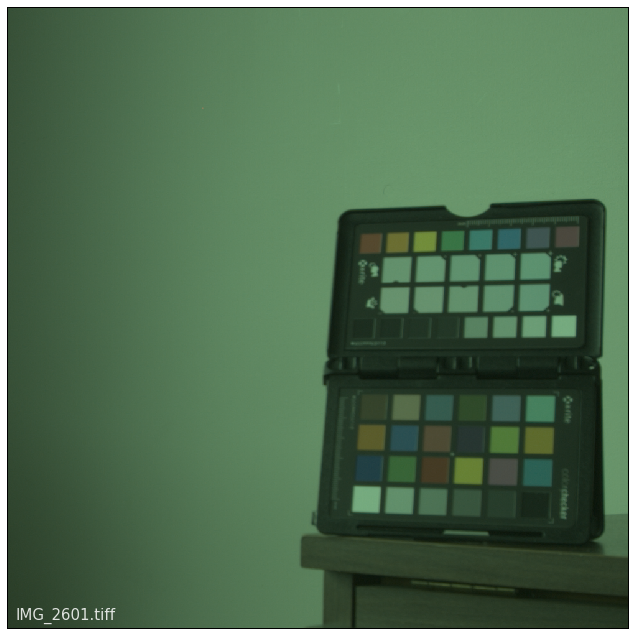

True

In [4]:
image_plot(OECF(colour.read_image(str(INTERMEDIATE_FILES[-2]))[1250:2250, 3000:4000, ...]),
           os.path.basename(INTERMEDIATE_FILES[-2]))

## Merging to Single Radiance Image

In [5]:
XYZ_TO_CAMERA_MATRIX = np.asarray(
    map(float, get_value(DNG_FILES[-2],
                         'ColorMatrix2').split())).reshape((3, 3))


def camera_space_to_sRGB(RGB, xyz_to_camera_matrix=XYZ_TO_CAMERA_MATRIX):
    XYZ = colour.dot_vector(
        np.linalg.inv(XYZ_TO_CAMERA_MATRIX), RGB)

    sRGB = colour.XYZ_to_sRGB(XYZ,
                              colour.ILLUMINANTS['cie_2_1931']['D50'],
                              transfer_function=False)
    return sRGB


def example_merge_from_raw_files(
        dng_files,
        output_directory,
        batch_size=9,
        weight_function=weighting_function_Debevec1997):
    for dng_files in colour.batch(dng_files, batch_size):
        image_stack = ImageStack()
        for dng_file in dng_files:
            image = Image(dng_file)
            image.read_metadata()
            image.path = str(dng_file.replace('dng', 'tiff'))
            image.read_data()
            image_data = camera_space_to_sRGB(image.data)
            image.data = highlights_recovery_blend(
                image_data, np.max(np.reshape(image.data, (-1, 3)), axis=0))
            image_stack.append(image)

        LOGGER.info('Image stack "F Number": {0}'.format(image_stack.f_number))
        LOGGER.info('Image stack "Exposure Time": {0}'.format(image_stack.exposure_time))
        LOGGER.info('Image stack "ISO": {0}'.format(image_stack.iso))

        path = os.path.join(
            output_directory,
            '{0}_{1}.{2}'.format(
                os.path.splitext(os.path.basename(image_stack.path[0]))[0],
                batch_size,
                'exr'))

        LOGGER.info('Merging "{0}"...'.format(path))
        image = radiance_image(image_stack, weight_function)

        LOGGER.info('Writing "{0}"...'.format(path))
        colour.write_image(image, path)

        return image, path


IMAGE, PATH = example_merge_from_raw_files(DNG_FILES, RESOURCES_DIRECTORY)


INFO:colour_hdri.exif:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2601.dng' file 'ColorMatrix2' exif tag value: '0.4716 0.0603 -0.083 -0.7798 1.5474 0.248 -0.1496 0.1937 0.6651'
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2598.dng" image metadata.
INFO:colour_hdri.exif:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2598.dng' file exif data.
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2598.tiff" image.
/Users/kelsolaar/Documents/Development/Environments/colour-hdri/lib/python2.7/site-packages/colour_hdri/recovery.py:44: RuntimeWarning: invalid value encountered in true_divide
  ratio = np.sqrt(s_c / s)
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-scienc

## Conversion from Camera Space to sRGB Colourspace

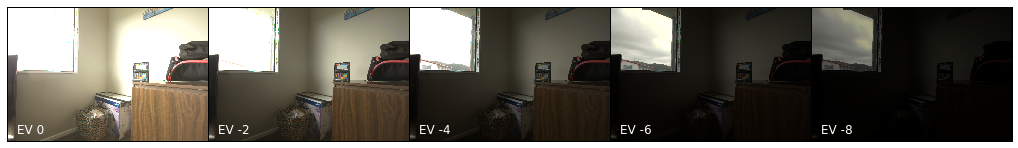

In [6]:
radiance_image_strip_plot(IMAGE)